This vignette demonstrates how to estimate spatial autocorrelation from residuals of multiple regression across the Western US ecoregion groups in the absence of any spatial sub-sampling

First, we will load the necessary packages to run the code

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#
# Author: Lewis Kunik - University of Utah
# Contact: lewis.kunik@utah.edu
#

#%%
#########################################
# Load packages
#########################################

# File system packages
import os  # operating system library
import sys
import glob
from pathlib import Path
import copy

# numerical/data management packages
import numpy as np
import xarray as xr 
import pandas as pd

# shapefile/geospatial packages
import geopandas as gpd
from shapely.geometry import mapping
from shapely.geometry import Point

# Stats packages
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# time and date packages
import time
from datetime import datetime as dt  # date time library
from datetime import timedelta

# Standard plotting packages
from matplotlib import pyplot as plt  # primary plotting module
from matplotlib.ticker import FuncFormatter as FFmt  # need this for formatting plot ticks

# Geospatial plotting packages
import cartopy.crs as ccrs  # cartopy is the best spatial plotting library i know
from cartopy.io import img_tiles  # cartopy's implementation of webtiles
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature




Define any global filepaths and variables that will be needed throughout the script 

In [ ]:

#########################################
# Define Global Filepaths
#########################################

dat_basedir = '/uufs/chpc.utah.edu/common/home/lin-group19/ltk/SIF/SIF_IAV/data/'
dat_dir_precip = '/uufs/chpc.utah.edu/common/home/lin-group19/ltk/SIF/SIF_IAV/data/TOT_WY_Precip'
EPA_ecoregion_dir = '/uufs/chpc.utah.edu/common/home/lin-group23/ltk/EPA/ecoregions/'
EPA_ecoregion_L3_file = os.path.join(EPA_ecoregion_dir, 'L3', 'WUS_cec_eco_l3.shp')

########################################
# Define Global Variables and constants
#########################################


#########################################
# Set plotting parameters
#########################################

plt.rcParams.update({
   'axes.labelsize': 16,
   'axes.titlesize': 16,
   'xtick.labelsize': 16,
   'ytick.labelsize': 15,
   'legend.fontsize': 13,
})

# use Google Satellite imagery as basemap
tiler = img_tiles.GoogleTiles(style='satellite')
crs = tiler.crs # set crs of map tiler
alpha = 0.8  # transparency 0-1
transform = ccrs.PlateCarree()  # transform specifies the crs that the data is in

tiler_zoom = 7  # define a zoom level of detail
extent = [-125.3, -102.7, 29.7, 50.3]  # [minx, maxx, miny, maxy], bounds for map

### Load state boundaries
fn = shpreader.natural_earth(
   resolution='10m', category='cultural', 
   name='admin_1_states_provinces',
)
reader = shpreader.Reader(fn)
states = [x for x in reader.records() if x.attributes["admin"] == "United States of America"] # get all states in US
states_geom = cfeature.ShapelyFeature([x.geometry for x in states], ccrs.PlateCarree())

# matplotlib map plotting functions
def z_axis_formatter(x, pos, deci=2):
   '''Format ticks to format with deci number of decimals'''

   return f'{x:.{deci}f}'



### Set specific global variables relevant to the analysis

In [3]:
num_reps = 1000

Define any functions that will be needed throughout the script

In [4]:
#########################################
# Define Global Functions
#########################################

# -----------------------------------------------------------------------
# Function to load xarray data and set CRS
# -----------------------------------------------------------------------
def load_xr(dat_xr_file, varname = None):
    if varname is not None:
        dat_xr = xr.open_dataset(dat_xr_file, decode_coords='all').sortby(['x', 'y'], ascending = True)[varname]
    else:
        dat_xr = xr.open_dataset(dat_xr_file, decode_coords='all').sortby(['x', 'y'], ascending = True)
    dat_xr.rio.write_crs(4326, inplace=True)
    return dat_xr



def xarray_to_long_df(da_dict, response_var_name):
    """
    Convert dictionary of xarray DataArrays to long format DataFrame
    suitable for mixed effects modeling
    """
    # Start with response variable - only keep essential coordinates
    response_da = da_dict[response_var_name]
    df = response_da.to_dataframe(name=response_var_name).reset_index()
    
    # Keep only the columns we need for merging and analysis
    essential_cols = ['x', 'y', response_var_name]
    if 'year' in df.columns:
        essential_cols.append('year')
    
    df = df[essential_cols].dropna(subset=[response_var_name])
    
    # Add explanatory variables one by one
    for var_name, da in da_dict.items():
        if var_name != response_var_name:
            # Convert to dataframe and keep only essential columns
            var_df = da.to_dataframe(name=var_name).reset_index()
            
            # Keep only coordinates and the variable of interest
            var_essential_cols = ['x', 'y', var_name]
            if 'year' in var_df.columns:
                var_essential_cols.append('year')
            
            var_df = var_df[var_essential_cols].dropna(subset=[var_name])
            
            # Handle time-invariant variables (no year dimension)
            if 'year' not in var_df.columns and 'year' in df.columns:
                # Replicate time-invariant data for each year
                years = df['year'].unique()
                var_df_expanded = []
                for year in years:
                    temp_df = var_df.copy()
                    temp_df['year'] = year
                    var_df_expanded.append(temp_df)
                var_df = pd.concat(var_df_expanded, ignore_index=True)
            
            # Determine merge columns
            merge_cols = ['x', 'y']
            if 'year' in var_df.columns:
                merge_cols.append('year')
                
            # Merge with main dataframe
            df = df.merge(var_df, on=merge_cols, how='inner')
    
    return df



def spatial_subsample_grid_probabilistic(df, spacing_deg=1.0, seed=None, verbose=False):
    """
    Subsample pixels by dividing domain into regular grid cells, then:
    1. Count valid pixels in each cell
    2. Sample one random pixel from each cell
    3. Include sampled pixel with probability proportional to cell density
    
    Cells with the most pixels have probability=1.0 (always included)
    Cells with fewer pixels have proportionally lower probability
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame with 'x' (longitude) and 'y' (latitude) columns
    spacing_deg : float
        Grid cell size in degrees (e.g., 1.0 for 1° x 1° cells)
    seed : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    DataFrame with probabilistically subsampled pixels
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Get unique pixel locations
    pixels = df[['pixel_id', 'x', 'y']].drop_duplicates()
    
    # Get domain extent
    x_min, x_max = pixels['x'].min(), pixels['x'].max()
    y_min, y_max = pixels['y'].min(), pixels['y'].max()
    
    # Create grid cell boundaries
    x_bins = np.arange(x_min, x_max + spacing_deg, spacing_deg)
    y_bins = np.arange(y_min, y_max + spacing_deg, spacing_deg)
    
    if verbose:
        print(f"Grid dimensions: {len(x_bins)-1} x {len(y_bins)-1} = {(len(x_bins)-1) * (len(y_bins)-1)} cells")

    # Assign each pixel to a grid cell
    pixels['x_cell'] = np.digitize(pixels['x'], x_bins) - 1
    pixels['y_cell'] = np.digitize(pixels['y'], y_bins) - 1
    pixels['cell_id'] = pixels['x_cell'].astype(str) + '_' + pixels['y_cell'].astype(str)
    
    # Count pixels per cell
    cell_counts = pixels.groupby('cell_id').size()
    max_count = cell_counts.max()
    if verbose:
        print(f"Pixels per cell - Min: {cell_counts.min()}, Max: {max_count}, Mean: {cell_counts.mean():.1f}")
    
    # Calculate probability for each cell (proportional to pixel count)
    cell_probabilities = cell_counts / max_count
    
    selected_pixels = []
    cell_info = []
    
    # For each cell, randomly sample one pixel and decide whether to include it
    for cell_id, cell_group in pixels.groupby('cell_id'):
        n_pixels_in_cell = len(cell_group)
        probability = cell_probabilities[cell_id]
        
        # Randomly select one pixel from this cell
        sampled_pixel = cell_group.sample(n=1, random_state=seed).iloc[0]
        
        # Include this pixel with probability proportional to cell density
        if np.random.random() < probability:
            selected_pixels.append(sampled_pixel['pixel_id'])
            cell_info.append({
                'cell_id': cell_id,
                'n_pixels': n_pixels_in_cell,
                'probability': probability,
                'included': True
            })
        else:
            cell_info.append({
                'cell_id': cell_id,
                'n_pixels': n_pixels_in_cell,
                'probability': probability,
                'included': False
            })
    
    # Create summary dataframe
    cell_summary = pd.DataFrame(cell_info)
    if verbose:
        print(f"\nOriginal pixels: {len(pixels)}")
        print(f"Grid cells with data: {len(cell_counts)}")
        print(f"Cells included in sample: {cell_summary['included'].sum()}")
        print(f"Final subsampled pixels: {len(selected_pixels)}")
        print(f"Reduction: {100 * (1 - len(selected_pixels)/len(pixels)):.1f}%")
        
        # Print probability distribution
        print(f"\nProbability distribution:")
        print(f"  Cells with p=1.0 (max density): {(cell_probabilities == 1.0).sum()}")
        print(f"  Cells with p>=0.75: {(cell_probabilities >= 0.75).sum()}")
        print(f"  Cells with p>=0.50: {(cell_probabilities >= 0.50).sum()}")
        print(f"  Cells with p>=0.25: {(cell_probabilities >= 0.25).sum()}")
        print(f"  Cells with p<0.25: {(cell_probabilities < 0.25).sum()}")
        
    # Filter original dataframe to keep only selected pixels
    df_subsampled = df[df['pixel_id'].isin(selected_pixels)].copy()
    
    # Optionally return cell summary for diagnostics
    df_subsampled.attrs['cell_summary'] = cell_summary
    df_subsampled.attrs['cell_probabilities'] = cell_probabilities
    
    return df_subsampled




### Load in ecoregion data

In [5]:

# Load EPA L3 Ecoregion file and define individual region geometries
ecoregion_l3_gdf = gpd.read_file(EPA_ecoregion_L3_file)
Region1 = ['Sierra Nevada']
Region2 = ['Cascades']
Region3 = ['Klamath Mountains']
Region4 = ['Coast Range']
Region5 = ['North Cascades']
Region6 = ['Columbia Mountains/Northern Rockies']
Region7 = ['Canadian Rockies']
Region8 = ['Blue Mountains']
Region9 = ['Idaho Batholith'] 
Region10 = ['Middle Rockies']
Region11 = ['Wasatch and Uinta Mountains']
Region12 = ['Southern Rockies']
Region13 = ['Arizona/New Mexico Mountains']
Region14 = ['Southern and Baja California Pine-Oak Mountains']
Region15 = ['Central Basin and Range']

ecoregion_l3_gdf_Region1 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region1)]
ecoregion_l3_gdf_Region2 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region2)]
ecoregion_l3_gdf_Region3 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region3)]
ecoregion_l3_gdf_Region4 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region4)]
ecoregion_l3_gdf_Region5 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region5)]
ecoregion_l3_gdf_Region6 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region6)]
ecoregion_l3_gdf_Region7 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region7)]
ecoregion_l3_gdf_Region8 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region8)]
ecoregion_l3_gdf_Region9 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region9)]
ecoregion_l3_gdf_Region10 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region10)]
ecoregion_l3_gdf_Region11 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region11)]
ecoregion_l3_gdf_Region12 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region12)]
ecoregion_l3_gdf_Region13 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region13)]
ecoregion_l3_gdf_Region14 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region14)]
ecoregion_l3_gdf_Region15 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region15)]


region_gdfs_Coastal = [ecoregion_l3_gdf_Region4]
region_gdfs_Pacific_Montane = [ecoregion_l3_gdf_Region2, ecoregion_l3_gdf_Region3,
                                ecoregion_l3_gdf_Region5]
region_gdfs_Mid_Montane = [ecoregion_l3_gdf_Region6, ecoregion_l3_gdf_Region7,
                        ecoregion_l3_gdf_Region1, ecoregion_l3_gdf_Region8, 
                        ecoregion_l3_gdf_Region9, ecoregion_l3_gdf_Region14]

region_gdfs_Rockies_group = [ecoregion_l3_gdf_Region10, ecoregion_l3_gdf_Region11,
                                ecoregion_l3_gdf_Region12]#,
                                # ecoregion_l3_gdf_Region15]
region_gdfs_AZNM_group = [ecoregion_l3_gdf_Region13]

# Combine GeoDataFrames for each region group
region_gdfs_Coastal_group = pd.concat(region_gdfs_Coastal, ignore_index=True)
region_gdfs_Pacific_Montane_group = pd.concat(region_gdfs_Pacific_Montane, ignore_index=True)
region_gdfs_Mid_Montane_group = pd.concat(region_gdfs_Mid_Montane, ignore_index=True)
region_gdfs_Rockies_group = pd.concat(region_gdfs_Rockies_group, ignore_index=True)
region_gdfs_AZNM_group = pd.concat(region_gdfs_AZNM_group, ignore_index=True)

# Calculate combined geometries
region_geom_Coastal = region_gdfs_Coastal_group.geometry
region_geom_Pacific_Montane = region_gdfs_Pacific_Montane_group.geometry
region_geom_Mid_Montane = region_gdfs_Mid_Montane_group.geometry
region_geom_Rockies = region_gdfs_Rockies_group.geometry
region_geom_AZNM = region_gdfs_AZNM_group.geometry

region_names = ['Coastal', 'Pacific_Montane', 'Mid_Montane', 'Rockies', 'AZNM']
region_geoms = [region_geom_Coastal, region_geom_Pacific_Montane, region_geom_Mid_Montane, region_geom_Rockies, region_geom_AZNM]

### Define minimum sampling distances for each ecoregion group based on spatial autocorrelation analysis
min_dists = [0.5, 1, 1, 1, 0.5] ## in deg; From previous jupyter notebook

In [6]:
### Define a function to plot the ecoregions, highlighting the current region

def plot_ecoregion_map(region_name, region_geom):

    #### Plot a map of ecoregions
    figsize = (8, 7)  # width, height in inches
    fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize=figsize)

    # Set extent of map before adding base img
    ax.set_extent(extent, crs=ccrs.PlateCarree())  # PlateCarree is default lat/lon
    ax.add_image(tiler, 5, interpolation='none', alpha=0.6) # Add base image

    alpha = 0.75  # transparency 0-1

    # Plot numbered text boxes at centroids of each region
    import matplotlib.patches as mpatches
    ax.add_feature(states_geom, facecolor="none", edgecolor="black", linewidth=1)

    ax.add_geometries(region_geom, crs=transform, facecolor="white", edgecolor='none', linewidth=1, zorder=1, alpha = 0.7)

    # for geom_region in region_geoms_Pacific_group:
    ax.add_geometries(region_geom_Coastal, crs=transform, facecolor="none", edgecolor='#332288', linewidth=1, zorder=1, alpha = 0.7)
    ax.add_geometries(region_geom_Pacific_Montane, crs=transform, facecolor="none", edgecolor='#117733', linewidth=1, zorder=1, alpha = 0.7)
    ax.add_geometries(region_geom_Mid_Montane, crs=transform, facecolor="none", edgecolor='#88CCEE', linewidth=1, zorder=1, alpha = 0.7)
    ax.add_geometries(region_geom_Rockies, crs=transform, facecolor="none", edgecolor='#DDCC77', linewidth=1, zorder=1, alpha = 0.7)
    ax.add_geometries(region_geom_AZNM, crs=transform, facecolor="none", edgecolor='#CC6677', linewidth=1, zorder=1, alpha = 0.7)
    plt.xlabel('lon', fontsize=10)
    plt.ylabel('lat', fontsize=10)
    plt.title(f'Region: {region_name}') # set axis title
    plt.show()

### Simple regression analysis with stochastic sampling

For each regression analysis (i.e. SIF vs some variable) we will perform many iterations of pixel selection using the lengthscales we found from the previous workbook (spatial autocorrelation lengthscale notebook). We will then represent the distribution of the coefficients and R2 values as the mean +/- standard deviation

### NOTE:
We have 4 different versions of "annualized" values, corresponding to 4 different averaging methods:
- Full growing season (all snow-free values in a given year)
- Peak growing season (top 6 snow-free avlues in a given year)
- 'Green-up' (all snow-free values prior to peak LAI in a given year)
- 'Senescence' (all snow-free values after peak LAI in a given year)


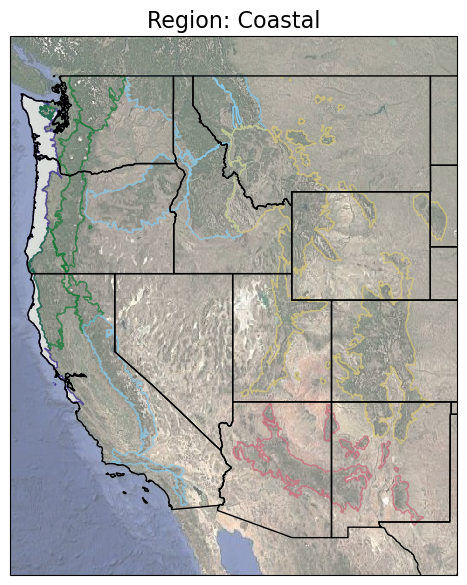

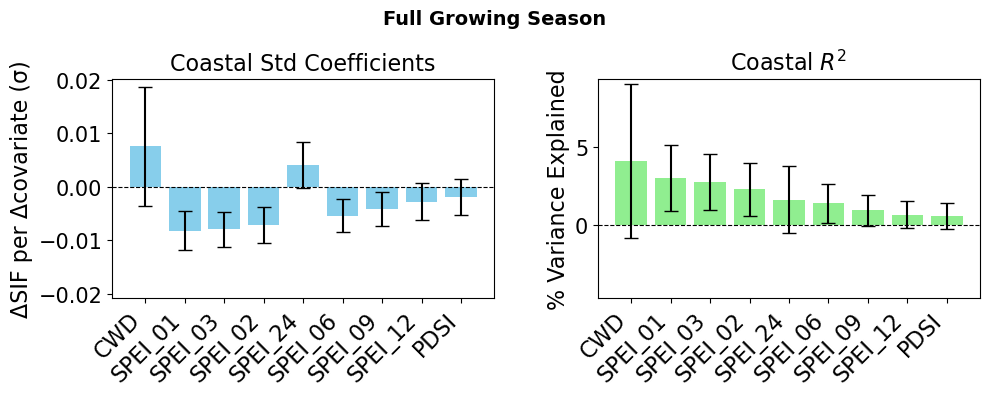

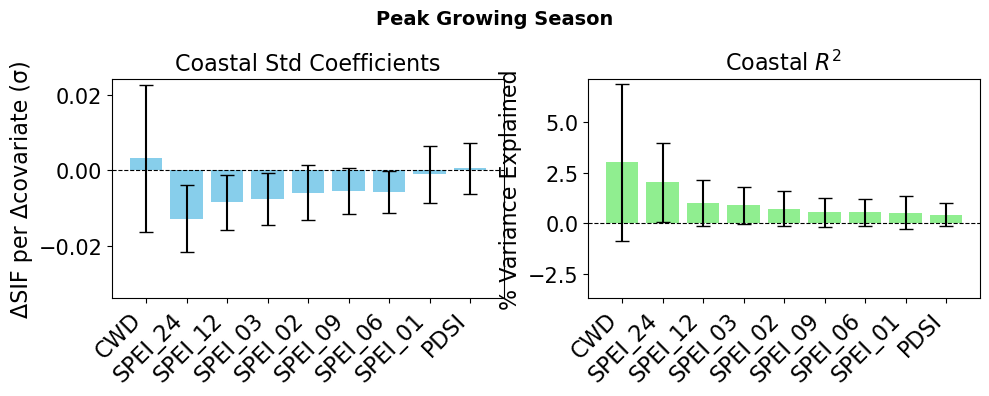

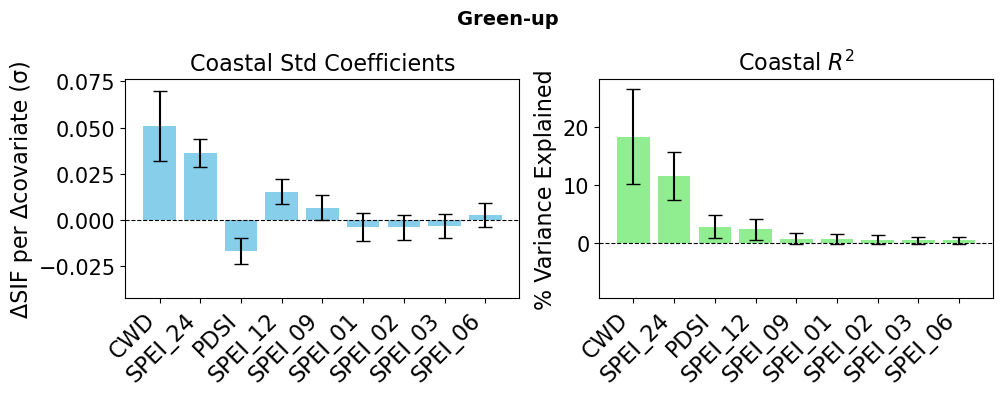

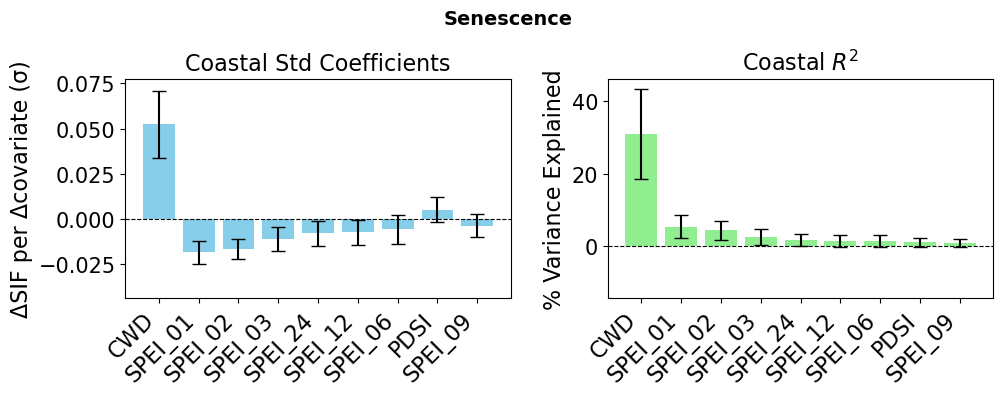

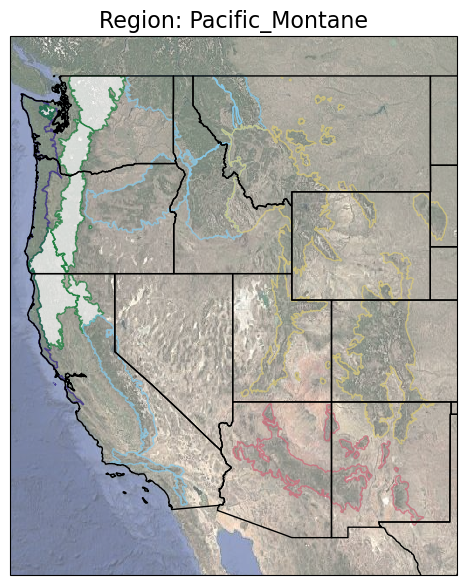

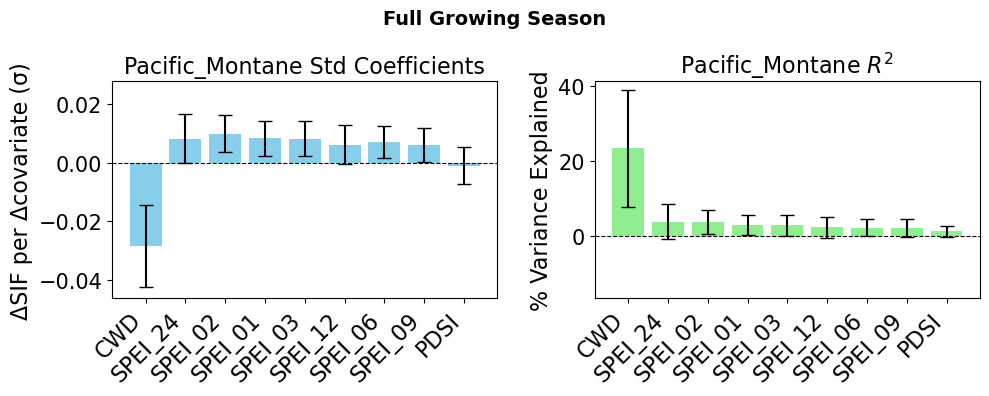

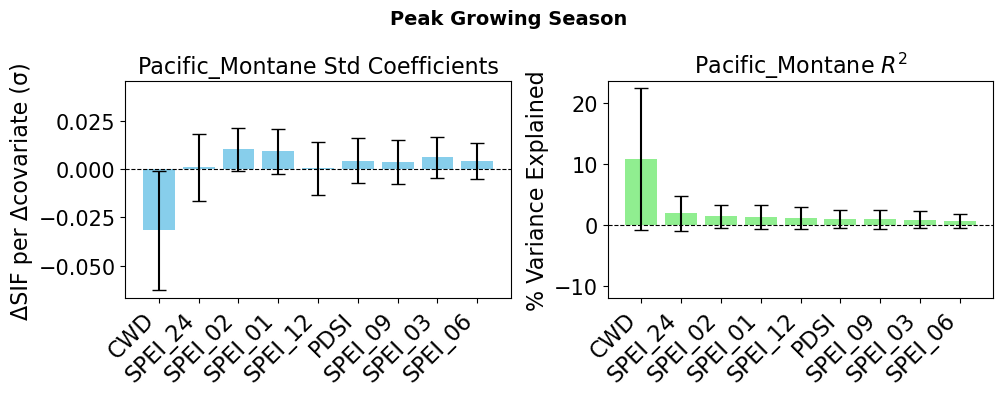

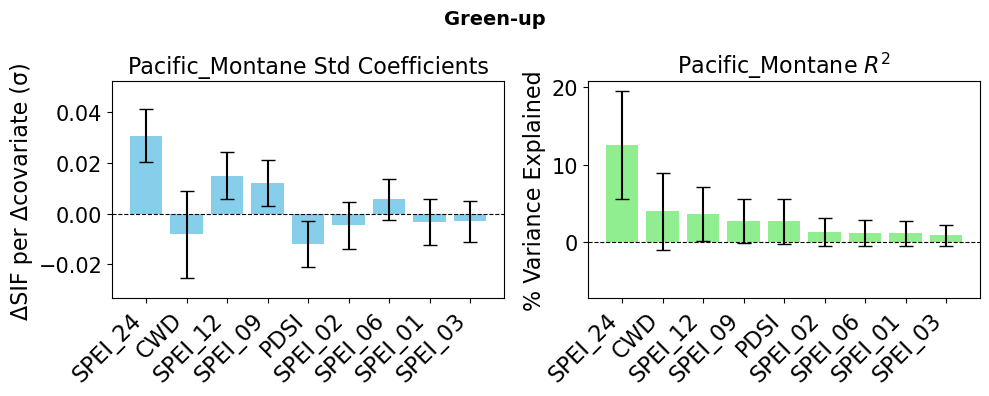

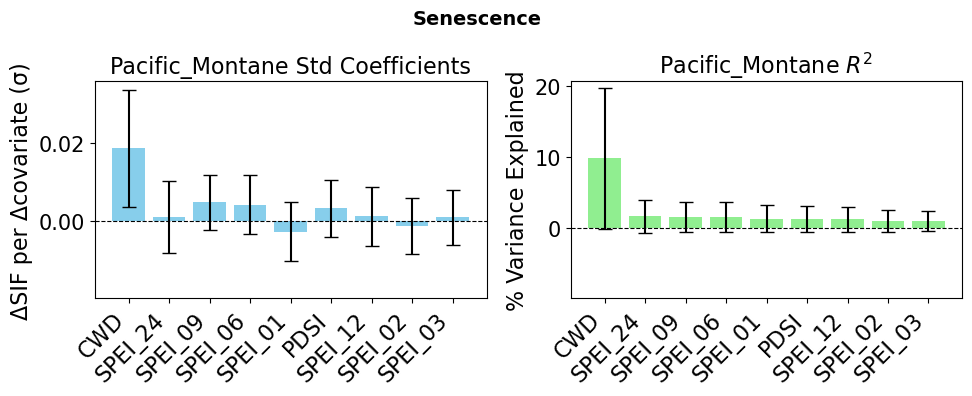

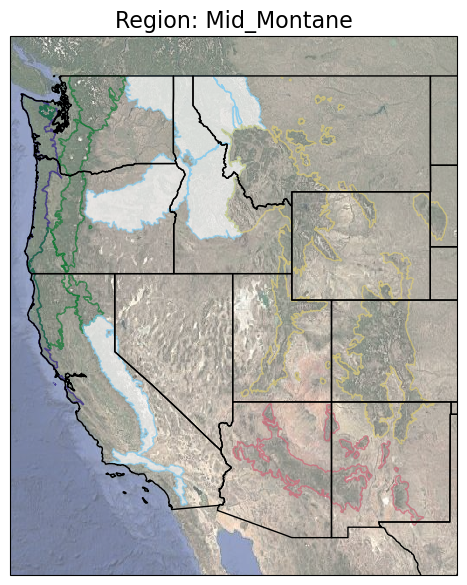

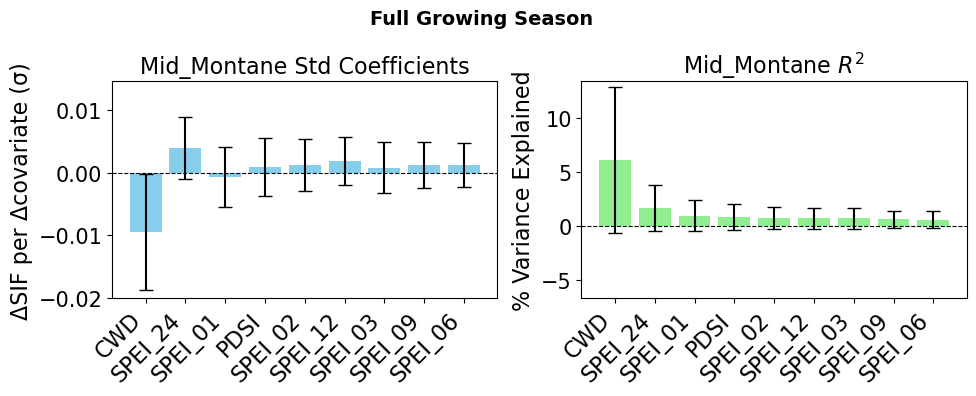

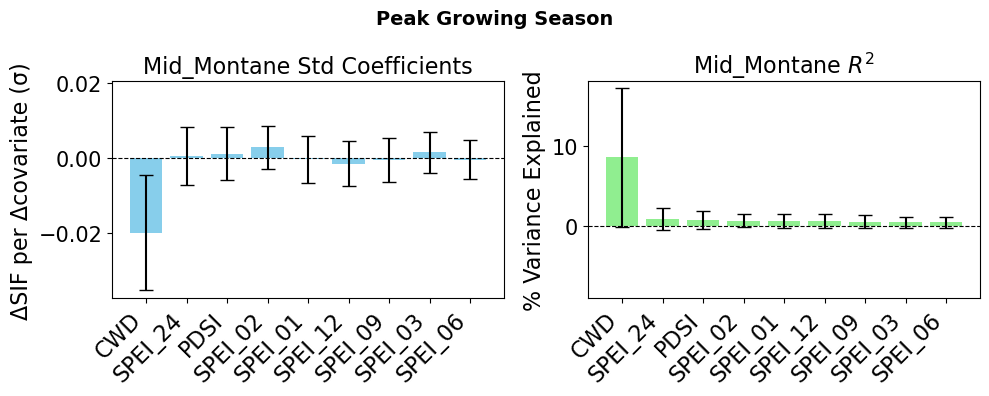

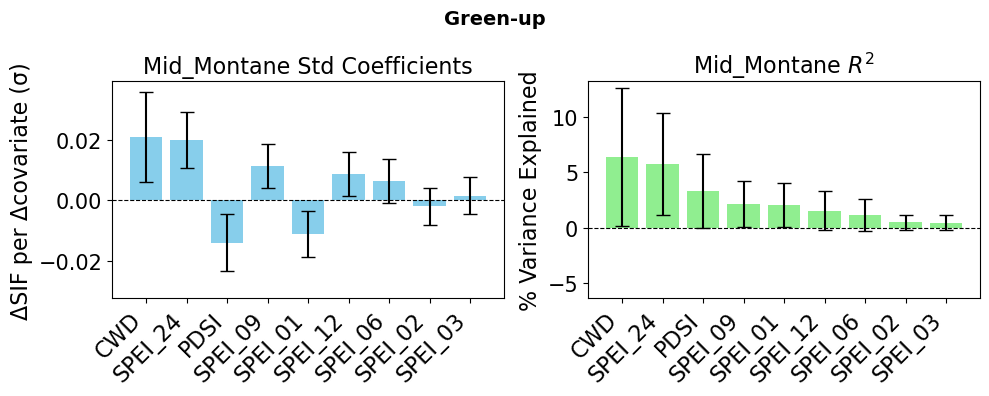

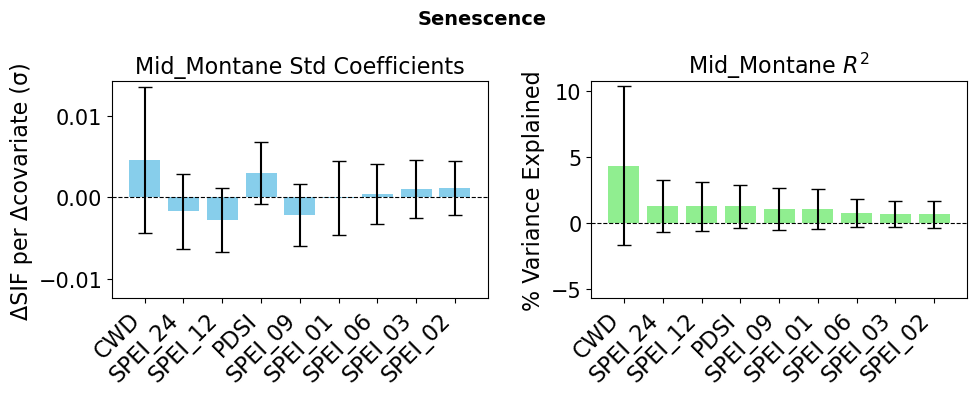

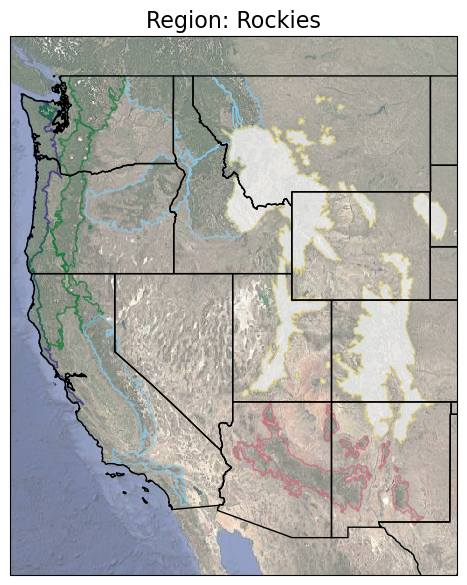

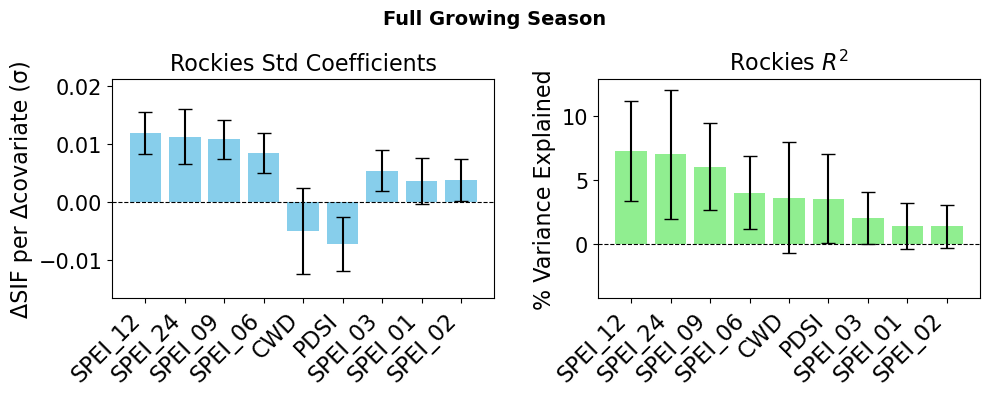

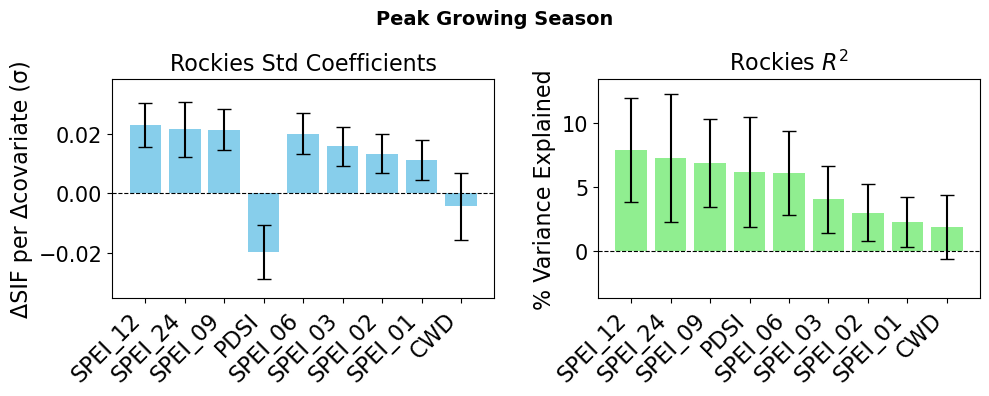

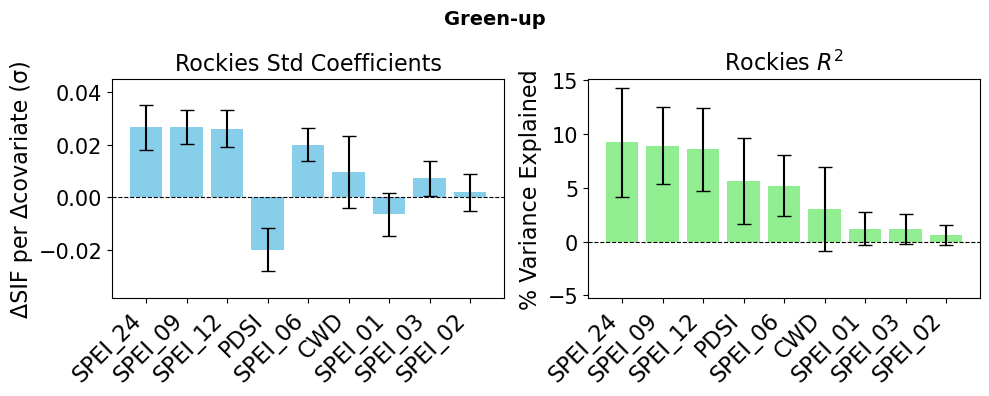

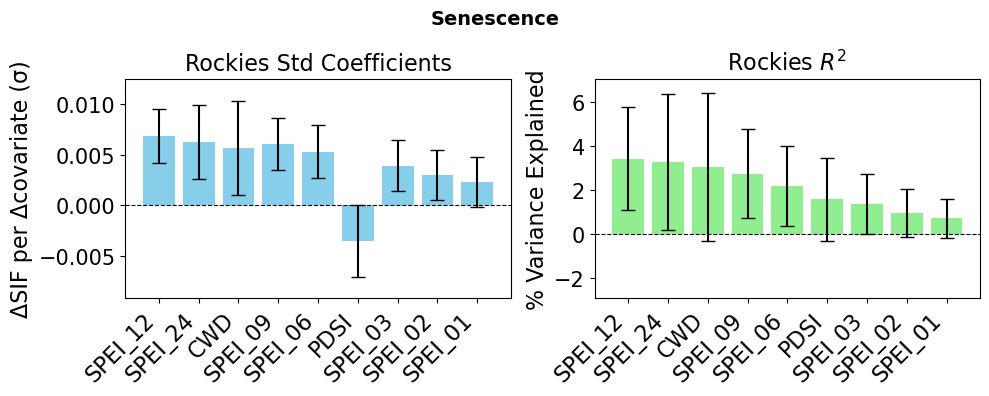

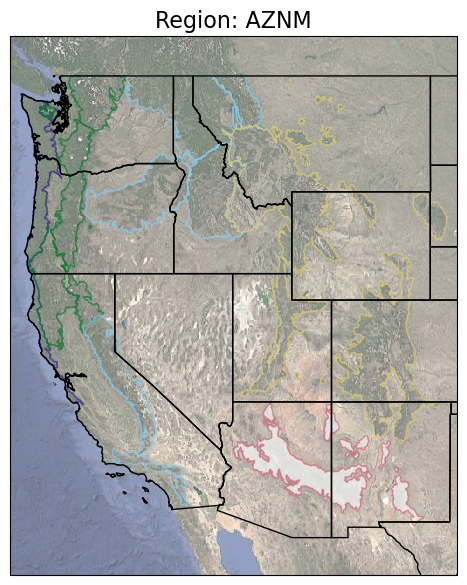

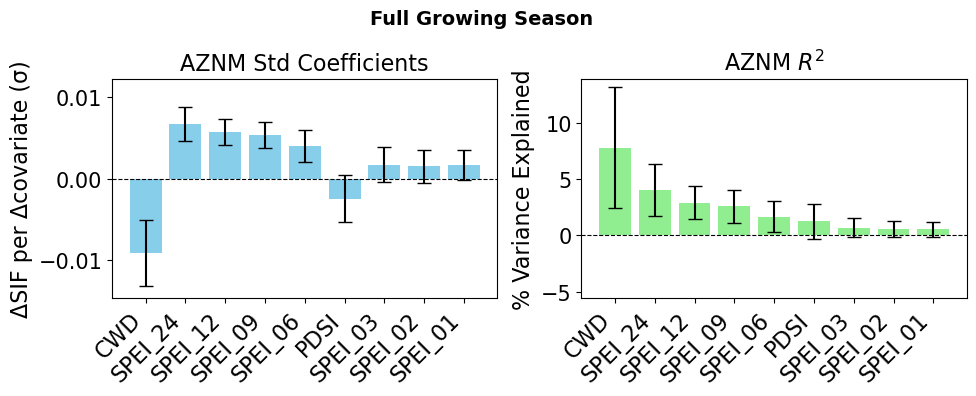

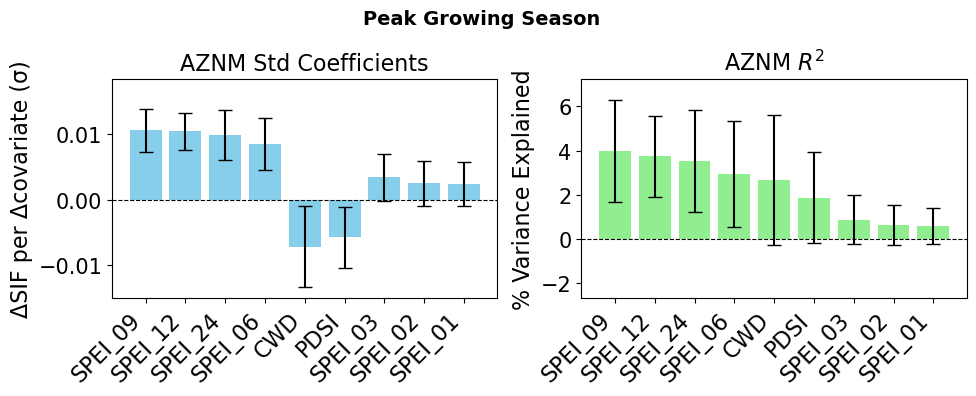

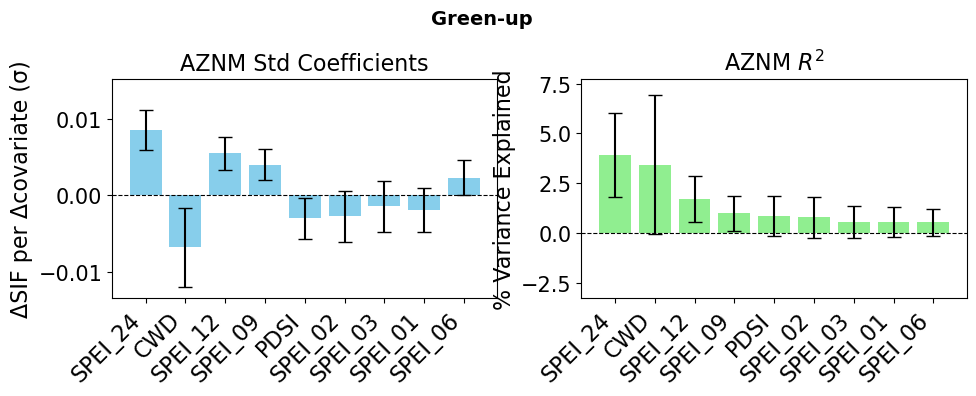

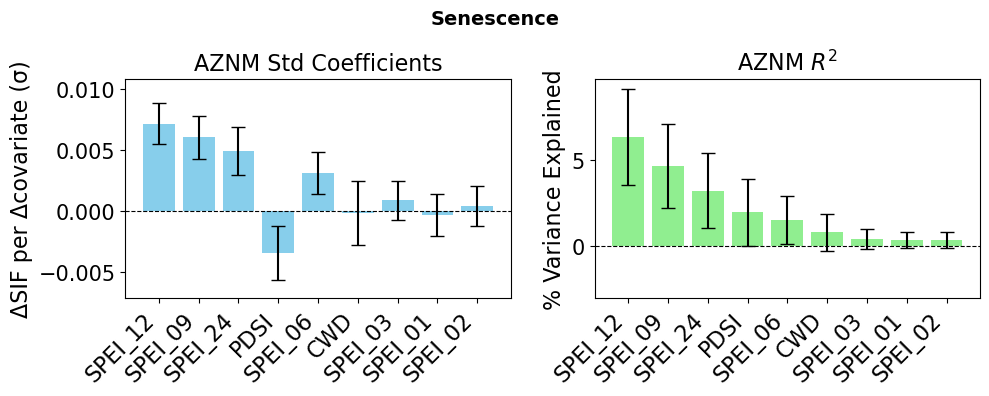

In [7]:
# Create an array of the xarray variables to test as covariates
covariates_descr = 'drought'
covariate_names = ['PDSI', 'CWD', 'SPEI_01', 'SPEI_02', 'SPEI_03', 'SPEI_06', 'SPEI_09', 'SPEI_12', 'SPEI_24']

timing_labels = ['FULL_YEAR', 'TOP_QUARTILE',  'PRE_PEAK_LAI','POST_PEAK_LAI']
timing_labels_descr = ['Full Growing Season', 'Peak Growing Season', 'Green-up', 'Senescence']

for ii, region_geom in enumerate(region_geoms):
    region_name = region_names[ii]
    plot_ecoregion_map(region_name, region_geom)
    for jj, timing_label in enumerate(timing_labels):
        # print(f"\nModeling SIF with annual averaging method: {timing_label}")
        dat_dir = os.path.join(dat_basedir, timing_label)  # directory where data files are stored, based on timing_label

        ## Define paths to data files
        TROPOMI_SIF_file = glob.glob(f'{dat_dir}/TROPOMI_SIF*.nc')[0]
        GRIDMET_PDSI_file = glob.glob(f'{dat_dir}/GRIDMET_PDSI*.nc')[0]
        TerraClimate_CWD_file = glob.glob(f'{dat_dir}/TerraClimate_CWD*.nc')[0]
        nClimGrid_SPEI_01_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_01*.nc')[0]
        nClimGrid_SPEI_02_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_02*.nc')[0]
        nClimGrid_SPEI_03_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_03*.nc')[0]
        nClimGrid_SPEI_06_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_06*.nc')[0]
        nClimGrid_SPEI_09_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_09*.nc')[0]
        nClimGrid_SPEI_12_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_12*.nc')[0]
        nClimGrid_SPEI_24_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_24*.nc')[0]

        ###### Load all the files as xarray dataarrays
        TROPOMI_SIF_xr = load_xr(TROPOMI_SIF_file, 'sifdc') # TROPOMI SIF
        GRIDMET_PDSI_xr = load_xr(GRIDMET_PDSI_file, 'pdsi')*-1 # GRIDMET PDSI # NOTE the negative sign!!!
        TerraClimate_CWD_xr = load_xr(TerraClimate_CWD_file, 'def') # TerraClimate CWD
        nClimGrid_SPEI_01_xr = load_xr(nClimGrid_SPEI_01_file, 'SPEI_pearson') # nClimGrid SPEI 01
        nClimGrid_SPEI_02_xr = load_xr(nClimGrid_SPEI_02_file, 'SPEI_pearson') # nClimGrid SPEI 02
        nClimGrid_SPEI_03_xr = load_xr(nClimGrid_SPEI_03_file, 'SPEI_pearson') # nClimGrid SPEI 03
        nClimGrid_SPEI_06_xr = load_xr(nClimGrid_SPEI_06_file, 'SPEI_pearson') # nClimGrid SPEI 06
        nClimGrid_SPEI_09_xr = load_xr(nClimGrid_SPEI_09_file, 'SPEI_pearson') # nClimGrid SPEI 09
        nClimGrid_SPEI_12_xr = load_xr(nClimGrid_SPEI_12_file, 'SPEI_pearson') # nClimGrid SPEI 12
        nClimGrid_SPEI_24_xr = load_xr(nClimGrid_SPEI_24_file, 'SPEI_pearson') # nClimGrid SPEI 24


        covariate_xr_arr = [GRIDMET_PDSI_xr, TerraClimate_CWD_xr, nClimGrid_SPEI_01_xr, nClimGrid_SPEI_02_xr, nClimGrid_SPEI_03_xr, nClimGrid_SPEI_06_xr, nClimGrid_SPEI_09_xr, nClimGrid_SPEI_12_xr, nClimGrid_SPEI_24_xr]
        covariate_results = {}

        for covariate_xr, covariate_name in zip(covariate_xr_arr, covariate_names):
            model_results = {}
            xr_data_dict = {
                'SIF': TROPOMI_SIF_xr.rio.clip(region_geom.geometry, drop=True),
                covariate_name: covariate_xr.rio.clip(region_geom.geometry, drop=True),
            }

            df_long = xarray_to_long_df(xr_data_dict, 'SIF')
            key_vars = ['SIF', covariate_name]

            # Add pixel_id, longitude, latitude
            df_long['pixel_id'] = df_long['x'].astype(str) + '_' + df_long['y'].astype(str)
            df_long['longitude'] = df_long['x']
            df_long['latitude'] = df_long['y']

            # Clean up - remove rows with missing values in key variables
            df_model = df_long.dropna(subset=key_vars).copy()

            # Standardize predictors
            all_predictors = [covariate_name]
            df_standardized = df_model.copy()
            df_standardized[all_predictors] = StandardScaler().fit_transform(df_model[all_predictors])

            # Fit multilinear regression model
            formula = f'SIF ~ {covariate_name}'
            coeff_list = []
            r2_list = []
            for iseed in range(num_reps):
                df_sampled = spatial_subsample_grid_probabilistic(df_standardized,
                                                            spacing_deg=min_dists[ii],
                                                            seed=iseed)

                try:
                    model = smf.ols(formula, data=df_sampled)
                    result = model.fit()
                    model_results['full_result'] = result
                    coeff_list.append(result.params[covariate_name])
                    r2_list.append(result.rsquared)
                except Exception as e:
                    print(f"Model fitting failed: {e}")

            model_result_params = {}
            model_result_params['coeff'] = np.mean(coeff_list)
            model_result_params['coeff_sd'] = np.std(coeff_list)
            model_result_params['r2'] = np.mean(r2_list)
            model_result_params['r2_sd'] = np.std(r2_list)
            
            covariate_results[covariate_name] = model_result_params

        # Print the 'coeff' for each covariate_name, sorted from highest to lowest
        sorted_coeffs = sorted(
            ((name, res['coeff']) for name, res in covariate_results.items()),
            key=lambda x: x[1], reverse=True
        )

        # Print the 'r2' for each covariate_name, sorted from highest to lowest
        sorted_r2 = sorted(
            ((name, res['r2']) for name, res in covariate_results.items()),
            key=lambda x: x[1], reverse=True
        )

        # Get the covariate order from sorted_r2
        covariate_order = [name for name, _ in sorted_r2]

        # Get values in this order
        coeffs = [covariate_results[name]['coeff'] for name in covariate_order]
        coeffs_sd = [covariate_results[name]['coeff_sd'] for name in covariate_order]
        r2s = [covariate_results[name]['r2']*100 for name in covariate_order]
        r2s_sd = [covariate_results[name]['r2_sd']*100 for name in covariate_order]

        coeffs_range = max(coeffs) - min(coeffs)
        coeffs_min = min(coeffs) - max(coeffs_sd) - 0.1*coeffs_range
        coeffs_max = max(coeffs) + max(coeffs_sd) + 0.1*coeffs_range

        # Marginal R^2 percentage limits
        r2_range = max(r2s) - min(r2s)
        r2_min = min(r2s) - max(r2s_sd) - 0.1*r2_range
        r2_max = max(r2s) + max(r2s_sd) + 0.1*r2_range

        fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=False)

        # Coefficient bar plot with error bars
        axes[0].bar(covariate_order, coeffs, color='skyblue', yerr=coeffs_sd, capsize=5)
        axes[0].axhline(0, color='black', linewidth=0.8, linestyle='--')
        axes[0].set_title(f'{region_name} Std Coefficients')
        axes[0].set_ylabel('ΔSIF per Δcovariate (σ)')
        axes[0].set_ylim(coeffs_min, coeffs_max)
        axes[0].set_xticks(range(len(covariate_order)))
        axes[0].set_xticklabels(covariate_order, rotation=45, ha='right')

        # R^2 bar plot with error bars
        axes[1].bar(covariate_order, r2s, color='lightgreen', yerr=r2s_sd, capsize=5)
        axes[1].axhline(0, color='black', linewidth=0.8, linestyle='--')
        axes[1].set_title(f'{region_name} $R^2$')
        axes[1].set_ylabel('% Variance Explained')
        axes[1].set_ylim(r2_min, r2_max)
        axes[1].set_xticks(range(len(covariate_order)))
        axes[1].set_xticklabels(covariate_order, rotation=45, ha='right')
        fig.suptitle(f'{timing_labels_descr[jj]}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()




